## XGBoost (Extreme Gradient Boosting)

In [37]:
import xgboost as xgb
import pandas as pd
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 15]


In [2]:
train = pd.read_csv('data/input_train.csv', encoding='ISO-8859-1')
test = pd.read_csv('data/input_test.csv', encoding='ISO-8859-1')

train_x = train.loc[:, train.columns.difference(["OutcomeType"])]
train_y = train.loc[:, "OutcomeType"]

test_x = test.loc[:, test.columns.difference(["OutcomeType"])]

In [3]:
#reproducibility
seed = 102
#train/test split
X_train, X_test, Y_train, Y_test = train_test_split(train_x, train_y, test_size=0.2, random_state=seed)

Želimo postaviti određene parametre za XGBoost algoritam.

- **n-estimators** -  određuje koliko ćemo puta pokrenuti ciklus
- **max_depth** - maksimalna dubina stabla
- **learning_rate** - smanjuje mogućnost overfittinga
- **colsample_bytree** - 
- **objective** - naš slučaj je mutliclass classification
- **num_class** - broj klasa u klasifikaciji

In [4]:
#XGBoost parameters
xgb_param_dist = {"n_estimators"     : 200,
                  "max_depth"        : 10,
                  "learning_rate"    : 0.6,
                  "colsample_bytree" : 0.7,
                  "objective"        : "multi:softmax",
                  "num_class" : 5}

dtrain = xgb.DMatrix(X_train, Y_train)
dtest = xgb.DMatrix(X_test, Y_test)
dtrain.num_row(), dtrain.num_col()

(21383, 63)

In [5]:
bst2 = xgb.XGBClassifier(**xgb_param_dist).fit(X_train,Y_train)

In [6]:
preds_prob = bst2.predict_proba(test_x)

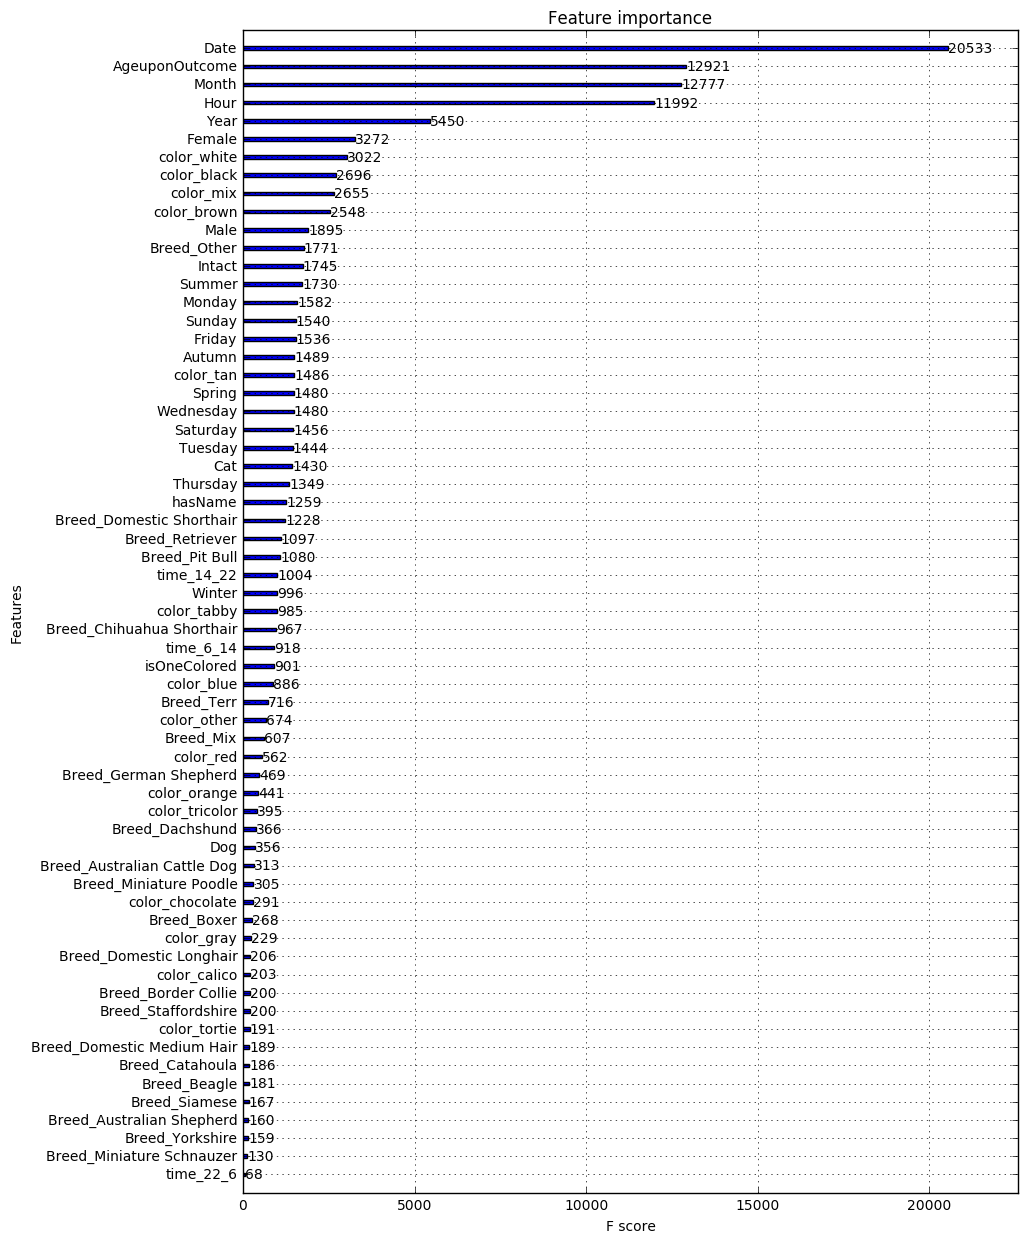

In [38]:
xgb.plot_importance(bst2)

Rezultat postignut na kaggle-u ovim načinom je **1.09483**.

### Hyper - parameter tuning

Za optimizaciju parametara koristili smo Randomizer Grid Search.

In [8]:
from scipy.stats import uniform
from scipy.stats import randint as sp_randint
from sklearn.grid_search import RandomizedSearchCV
from sklearn.cross_validation import StratifiedKFold
import numpy as np

k_fold = 5
cv = StratifiedKFold(train_y,n_folds=k_fold,shuffle=True)

xgb_param_dist = {"n_estimators" : np.arange(10, 250, 10),
                    "max_depth": sp_randint(2, 31),
                    "learning_rate" : uniform(loc = 0.01, scale=0.2),
                    "colsample_bytree" : uniform(loc = 0.3, scale = 0.7),
                    "subsample" : uniform(loc = 0.0, scale = 0.7),
                    "objective" : "multi:softmax"}

xgb_clf = xgb.XGBClassifier()
n_iter_search = 30

xgb_random_search = RandomizedSearchCV(xgb_clf, param_distributions = xgb_param_dist,
                                       n_iter = n_iter_search, cv=cv, scoring='log_loss', random_state = 123, n_jobs = 8, verbose = 1)
%time xgb_random_search.fit(train_x, train_y)
                                       
xgb_clf = xgb_random_search.best_estimator_

print("Best randomized search score - %s" % xgb_random_search.best_score_)

C:\Users\Iva\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed: 17.2min
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed: 76.8min finished


Wall time: 1h 18min 36s
Best randomized search score - -0.7450247481517691


In [9]:
#Najbolji model dobiven optimizacijom
xgb_clf

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.66763483792797729, gamma=0,
       learning_rate=0.07352705549149606, max_delta_step=0, max_depth=9,
       min_child_weight=1, missing=None, n_estimators=180, n_jobs=1,
       nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.3827033431731755)

In [10]:
#Pokrecemo predikciju na najboljem modelu
xgb_clf.get_booster().save_model("best_est_model.model")
best_m = xgb.Booster({'nthread' : 8}) #init model
best_m.load_model('best_est_model.model') # load data
pred = best_m.predict(xgb.DMatrix(test_x))

In [11]:
pred

array([[  1.48596969e-02,   1.11232337e-03,   3.28979604e-02,
          1.15974016e-01,   8.35156024e-01],
       [  8.16735446e-01,   6.83731923e-04,   9.34915897e-03,
          1.44421145e-01,   2.88104825e-02],
       [  4.61535752e-01,   1.57496578e-03,   1.39810266e-02,
          2.90502369e-01,   2.32405856e-01],
       ..., 
       [  8.21644964e-04,   3.43271066e-03,   6.90809172e-03,
          1.77825836e-03,   9.87059236e-01],
       [  3.98602933e-01,   8.30258126e-04,   1.68114714e-02,
          5.35393357e-01,   4.83619757e-02],
       [  2.99387760e-02,   2.28601205e-03,   1.08326599e-01,
          5.60329199e-01,   2.99119443e-01]], dtype=float32)

In [40]:
final_results = pd.DataFrame(pred)
final_results.columns = ['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer']
final_results.index.name = 'ID'
final_results.index = final_results.index + 1

final_results = final_results[['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer']]

final_results.to_csv('results4.csv')

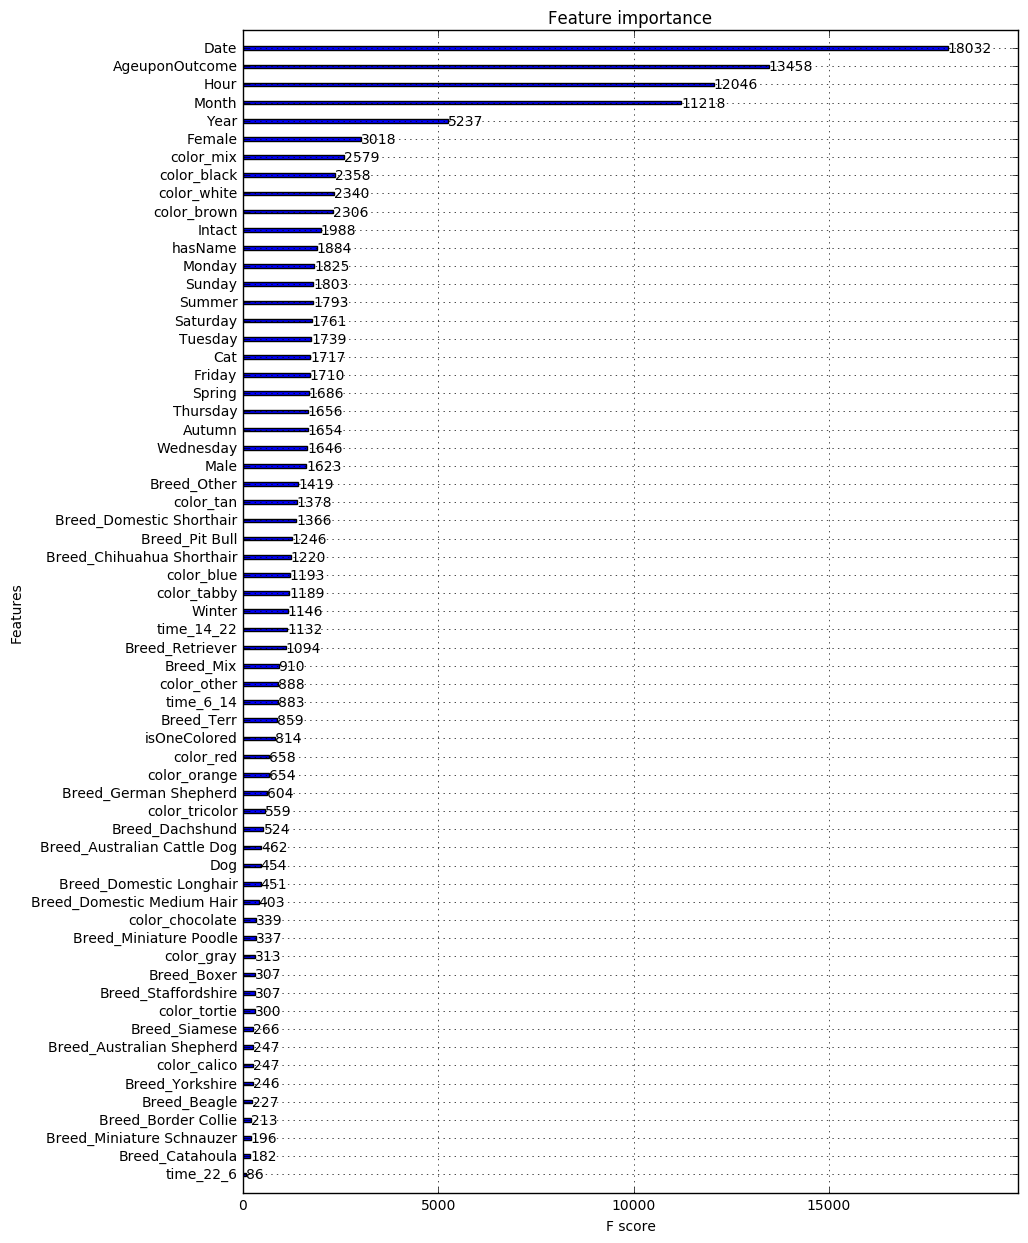

In [39]:
xgb.plot_importance(best_m)

Predikcija ovim modelom na kaggleu je postigla rezultat **0.72464**.